# Bitcoin - Buy or Sell?

## Load and Clean Data

In [1]:
import numpy as np
import pandas as pd
import scipy
import datetime as datetime
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import residuals_plot
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import pacf, adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import rmse, aic
import fbprophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import math
import pmdarima as pm
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson, jarque_bera

%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
# Load data to forecast
bitcoin = pd.read_csv('yahoo_BTC-USD_d_train.csv')

# Load external variables/features
cpi = pd.read_csv('yahoo_CPI_d.csv')
dow = pd.read_csv('yahoo_DJI_d.csv')
sp = pd.read_csv('yahoo_SP500_d.csv')
usd = pd.read_csv('yahoo_USD_d.csv')
vix = pd.read_csv('yahoo_VIX_d.csv')
interest = pd.read_csv('fed_interest_rates_us.csv')
trend = pd.read_csv('trend_bitcoin.csv')
unemploy = pd.read_csv('fed_bls_unemployment_us.csv')

# Load actual data to evaluate forecast
actual = pd.read_csv('yahoo_BTC-USD_d_test.csv')

In [3]:
# Add time series 'date' column to actual data frame
actual['date'] = pd.to_datetime(actual['Date'])

# Drop unwanted columns
actual.drop(['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

# Rename column
actual.rename(columns={'Close': 'actual_close'}, inplace=True)

# Use forward fill to fill in missing values
actual.fillna(method='ffill', inplace=True)

# Check data frame
actual

,actual_close,date
0,7200.174316,2020-01-01
1,6985.470215,2020-01-02
2,7344.884277,2020-01-03
3,7410.656738,2020-01-04
4,7411.317383,2020-01-05
...,...,...
98,7334.098633,2020-04-08
99,7302.089355,2020-04-09
100,7302.089355,2020-04-10
101,7302.089355,2020-04-11


In [4]:
# Add time series 'date' column to unemployment data frame
unemploy['date'] = pd.date_range(start='2014-01-01', end='2020-03-01', normalize=True, freq='MS')

# Drop unwanted column
unemploy.drop(['Series ID', 'Year', 'Period'], axis=1, inplace=True)

# Rename column
unemploy.rename(columns={'Value': 'unemploy'}, inplace=True)

# Check data frame
unemploy.head()

,unemploy,date
0,6.6,2014-01-01
1,6.7,2014-02-01
2,6.7,2014-03-01
3,6.2,2014-04-01
4,6.3,2014-05-01


In [5]:
# Add time series 'date' column to trend data frame
trend['date'] = pd.to_datetime(trend['Month'])

# Drop unwanted column
trend.drop('Month', axis=1, inplace=True)

# Rename column
trend.rename(columns={'bitcoin: (Worldwide)': 'trend'}, inplace=True)

# Check data frame
trend.head()

,trend,date
0,3,2014-12-01
1,3,2015-01-01
2,3,2015-02-01
3,3,2015-03-01
4,2,2015-04-01


In [6]:
# Add time series 'date' column to interest data frame
interest['date'] = pd.to_datetime(interest['Series Description'])

# Drop unwanted columns
col_to_drop = interest.columns.to_list()
col_to_drop.remove('Market yield on U.S. Treasury securities at 1-month   constant maturity, quoted on investment basis')
col_to_drop.remove('date')

interest.drop(col_to_drop, axis=1, inplace=True)

# Rename column to interest
interest.rename(columns={'Market yield on U.S. Treasury securities at 1-month   constant maturity, quoted on investment basis': 'interest'}, inplace=True)

# Make interest data numeric
interest['interest'] = pd.to_numeric(interest['interest'], errors='coerce')

# Check data frame
interest.head()

,interest,date
0,0.01,2014-12-01
1,0.04,2014-12-02
2,0.03,2014-12-03
3,0.03,2014-12-04
4,0.02,2014-12-05


In [7]:
# Make list of data frames that need to be cleaned
# and list of columns to drop
df_to_clean = [bitcoin, cpi, dow, sp, usd, vix]
col_to_drop = ['Open', 'High', 'Low', 'Adj Close', 'Volume']

# Rename 'Date' column to 'date', clarify 'Close' column,
# change 'date' column from object to datetime, and drop
# unwanted columns
for i, df in enumerate(df_to_clean):
    name_list = ['bitcoin', 'cpi', 'dow', 'sp', 'usd', 'vix']
    df.rename(columns={'Date': 'date', 'Close': '{}_close'.format(name_list[i])}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df.drop(col_to_drop, axis=1, inplace=True)

In [8]:
# Check data frames
bitcoin.head()

,date,bitcoin_close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


In [9]:
cpi.head()

,date,cpi_close
0,2014-12-01,26.660000
1,2014-12-02,26.690001
2,2014-12-03,26.750000
3,2014-12-04,26.670000
4,2014-12-05,26.680000


In [10]:
dow.head()

,date,dow_close
0,2014-12-01,17776.800781
1,2014-12-02,17879.550781
2,2014-12-03,17912.619141
3,2014-12-04,17900.099609
4,2014-12-05,17958.789063


In [11]:
sp.head()

,date,sp_close
0,2014-12-01,2053.439941
1,2014-12-02,2066.550049
2,2014-12-03,2074.330078
3,2014-12-04,2071.919922
4,2014-12-05,2075.370117


In [12]:
usd.head()

,date,usd_close
0,2014-12-01,87.949997
1,2014-12-02,88.650002
2,2014-12-03,88.959999
3,2014-12-04,88.699997
4,2014-12-05,89.330002


In [13]:
vix.head()

,date,vix_close
0,2014-12-01,14.16
1,2014-12-02,12.85
2,2014-12-03,12.50
3,2014-12-04,12.38
4,2014-12-05,11.89


In [14]:
# Make final data frame to store all variables of interest
final = bitcoin[['date', 'bitcoin_close']].copy()
final.head()

,date,bitcoin_close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


In [15]:
# Merge all data frames into one
df_to_merge = [cpi, dow, sp, usd, vix]
for i, df in enumerate(df_to_merge):
    name_list = ['cpi', 'dow', 'sp', 'usd', 'vix']
    final = final.merge(df[['date', '{}_close'.format(name_list[i])]], how='inner', on='date')
    
final = final.merge(interest[['date','interest']], how='inner', left_on='date', right_on='date')
final = final.merge(trend[['date','trend']], how='left', left_on='date', right_on='date')
final = final.merge(unemploy[['date','unemploy']], how='left', left_on='date', right_on='date')

# Check data types
final.dtypes

date             datetime64[ns]
bitcoin_close           float64
cpi_close               float64
dow_close               float64
sp_close                float64
usd_close               float64
vix_close               float64
interest                float64
trend                   float64
unemploy                float64
dtype: object

In [16]:
# Use forward fill to fill in missing trend values
final['trend'].ffill(inplace=True)

# Use forward fill to fill in missing unemploy values
final['unemploy'].ffill(inplace=True)

In [17]:
# Check final data frame
final

,date,bitcoin_close,cpi_close,dow_close,sp_close,usd_close,vix_close,interest,trend,unemploy
0,2014-12-01,379.244995,26.660000,17776.800781,2053.439941,87.949997,14.16,0.01,3.0,5.6
1,2014-12-02,381.315002,26.690001,17879.550781,2066.550049,88.650002,12.85,0.04,3.0,5.6
2,2014-12-03,375.010010,26.750000,17912.619141,2074.330078,88.959999,12.50,0.03,3.0,5.6
3,2014-12-04,369.604004,26.670000,17900.099609,2071.919922,88.699997,12.38,0.03,3.0,5.6
4,2014-12-05,376.854004,26.680000,17958.789063,2075.370117,89.330002,11.89,0.02,3.0,5.6
...,...,...,...,...,...,...,...,...,...,...
1273,2019-12-24,7322.532227,28.469999,28515.449219,3223.379883,NaN,12.67,1.55,11.0,3.5
1274,2019-12-26,7238.966797,28.490000,28621.390625,3239.909912,97.589996,12.65,1.59,11.0,3.5
1275,2019-12-27,7290.088379,28.520000,28645.259766,3240.020020,96.919998,13.43,1.56,11.0,3.5
1276,2019-12-30,7292.995117,27.879999,28462.140625,3221.290039,96.739998,14.82,1.51,11.0,3.5


In [18]:
# Check for any remaining missing values
final.isnull().sum()

date             0
bitcoin_close    0
cpi_close        0
dow_close        0
sp_close         0
usd_close        9
vix_close        0
interest         7
trend            0
unemploy         0
dtype: int64

In [19]:
# Use forward fill to fill in missing values
final.fillna(method='ffill', inplace=True)

# Reset index
final.reset_index(inplace=True, drop=True)

# Check final data frame
final

,date,bitcoin_close,cpi_close,dow_close,sp_close,usd_close,vix_close,interest,trend,unemploy
0,2014-12-01,379.244995,26.660000,17776.800781,2053.439941,87.949997,14.16,0.01,3.0,5.6
1,2014-12-02,381.315002,26.690001,17879.550781,2066.550049,88.650002,12.85,0.04,3.0,5.6
2,2014-12-03,375.010010,26.750000,17912.619141,2074.330078,88.959999,12.50,0.03,3.0,5.6
3,2014-12-04,369.604004,26.670000,17900.099609,2071.919922,88.699997,12.38,0.03,3.0,5.6
4,2014-12-05,376.854004,26.680000,17958.789063,2075.370117,89.330002,11.89,0.02,3.0,5.6
...,...,...,...,...,...,...,...,...,...,...
1273,2019-12-24,7322.532227,28.469999,28515.449219,3223.379883,97.680000,12.67,1.55,11.0,3.5
1274,2019-12-26,7238.966797,28.490000,28621.390625,3239.909912,97.589996,12.65,1.59,11.0,3.5
1275,2019-12-27,7290.088379,28.520000,28645.259766,3240.020020,96.919998,13.43,1.56,11.0,3.5
1276,2019-12-30,7292.995117,27.879999,28462.140625,3221.290039,96.739998,14.82,1.51,11.0,3.5


In [20]:
# Recheck for missing values
final.isnull().sum()

date             0
bitcoin_close    0
cpi_close        0
dow_close        0
sp_close         0
usd_close        0
vix_close        0
interest         0
trend            0
unemploy         0
dtype: int64

This is the final data frame from which I will pull for the remaining analyses.

## Explore Data

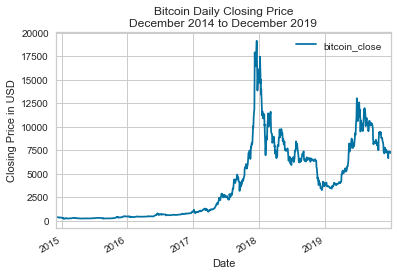

In [21]:
# Plot bitcoin time series
final.plot(x='date', y='bitcoin_close')
plt.title('Bitcoin Daily Closing Price\nDecember 2014 to December 2019')
plt.xlabel('Date')
plt.ylabel('Closing Price in USD')
plt.show()

Since bitcoin (and cryptocurrency in general) didn't really explode until mid-2017, the historical data is a bit limited. The time series above suggests that there may be some seasonality, perhaps yearly, but it is difficult to tell with only about 1.5 seasons.

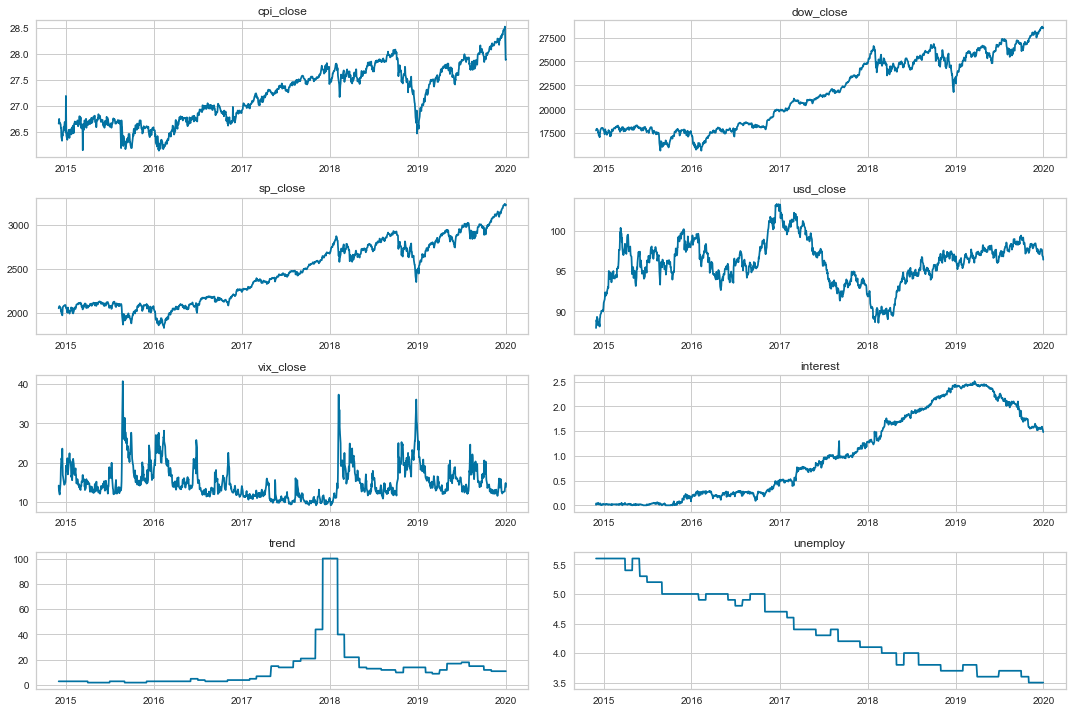

In [22]:
# Plot 8 external variables
column_list = ['cpi_close', 'dow_close', 'sp_close', 'usd_close',
               'vix_close', 'interest', 'trend', 'unemploy']

plt.figure(figsize=(15, 10))

for i, col in enumerate(column_list):
    plt.subplot(4, 2, i + 1)
    plt.plot(final['date'], final[col])
    plt.title(col)

# Show plots
plt.tight_layout()
plt.show()

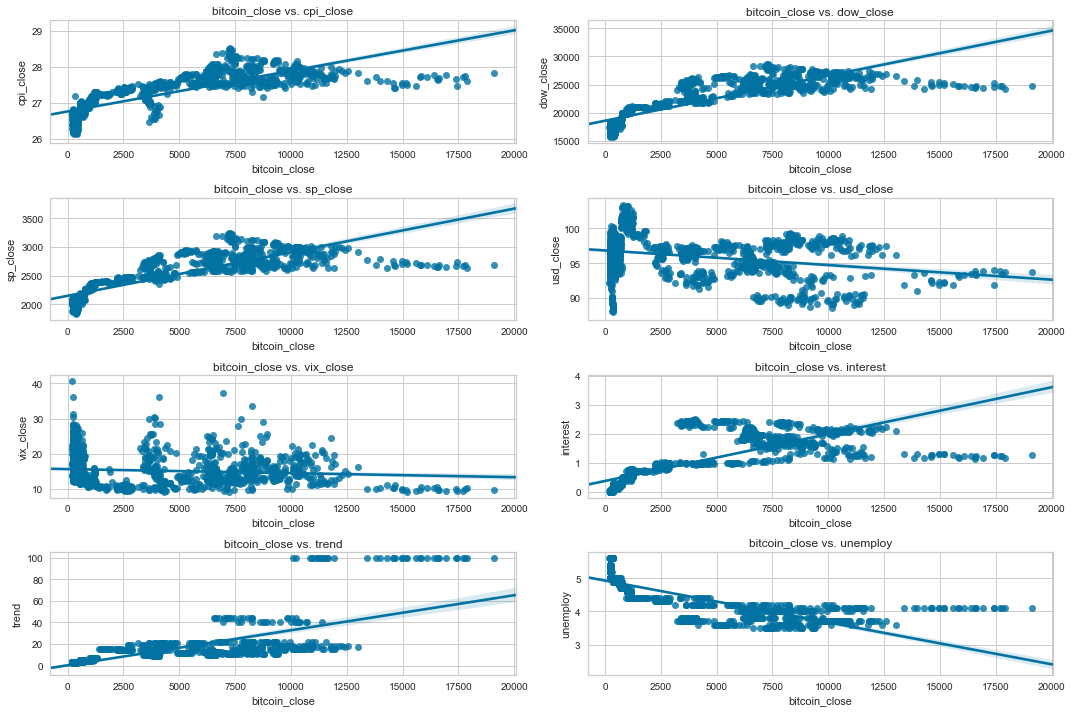

In [23]:
# Plot bitcoin vs. 8 external variables to evaluate
# bivariate relationships
column_list = ['cpi_close', 'dow_close', 'sp_close', 'usd_close',
               'vix_close', 'interest', 'trend', 'unemploy']

plt.figure(figsize=(15, 10))

for i, col in enumerate(column_list):
    plt.subplot(4, 2, i + 1)
    sns.regplot(x=final['bitcoin_close'], y=final[col])
    plt.title('bitcoin_close vs. ' + col)
    plt.xlabel('bitcoin_close')
    plt.ylabel(col)

# Show plots
plt.tight_layout()
plt.show()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


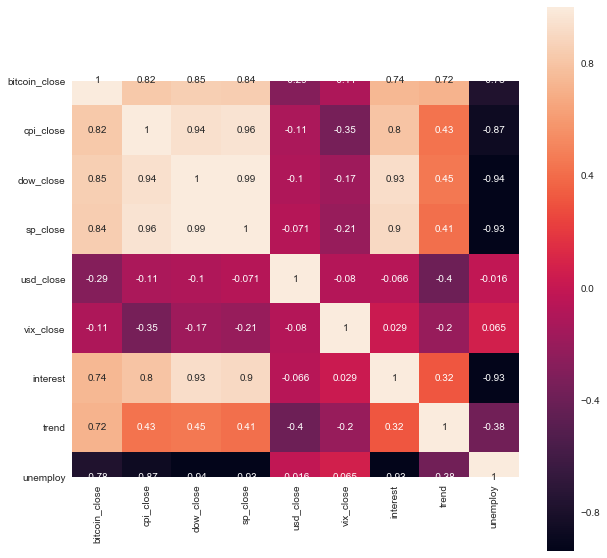

In [24]:
# Plot correlation matrix as heat meap
corr_mat = final.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_mat, annot=True, square=True)

plt.show()

As demonstrated in the univariate plots, bivariate plots, and correlation matrix heatmap, the closing bitcoin price is most closely associated with google search trend (0.72), interest rate (0.74), S&P500 closing price (0.84), DOW closing price (0.85), and CPI closing price (0.82). Interest rate, S&P50 closing price, DOW closing price, and CPI closing price are also highly correlated with each other.

## Build and Evaluate Models

### Facebook Prophet Model
First, I will forecast the closing price of bitcoin using the Facebook Prophet model (trends, seasonalities, holidays). This is an additive model. Generally speaking, it works via a process of curve-fitting, which is in contrast to other time series models, such as ARIMA, that rely on temporal dependencies within the data.

In [25]:
# Create new data frame for bitcoin prices
gm = final[['date', 'bitcoin_close']].copy()
gm.rename(columns={'date': 'ds', 'bitcoin_close': 'y'}, inplace=True)

# Check end of data frame
gm.tail()

,ds,y
1273,2019-12-24,7322.532227
1274,2019-12-26,7238.966797
1275,2019-12-27,7290.088379
1276,2019-12-30,7292.995117
1277,2019-12-31,7193.599121


In [26]:
# Instantiate new prophet object and fit model
gm_prophet = fbprophet.Prophet(growth='linear',
                               seasonality_mode='additive',
                               changepoint_prior_scale=1,
                               daily_seasonality=False,
                               weekly_seasonality=False,
                               yearly_seasonality=False
                               ).add_seasonality(
                                    name='custom',
                                    period=450,
                                    fourier_order=10)

gm_prophet.fit(gm)

# Use model to forecast daily bitcoin prices 90
# days into the future
gm_forecast = gm_prophet.make_future_dataframe(periods=90, freq='D')
gm_forecast = gm_prophet.predict(gm_forecast)

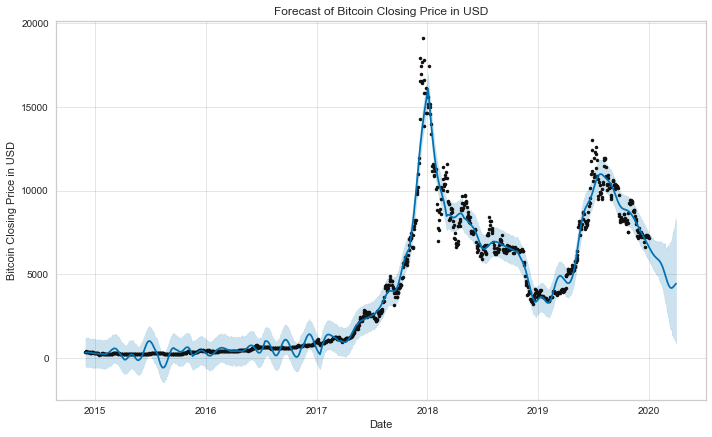

In [27]:
# Plot the actual prices along with the forecast
gm_prophet.plot(gm_forecast, xlabel='Date', ylabel='Bitcoin Closing Price in USD')
plt.title('Forecast of Bitcoin Closing Price in USD')
plt.show()

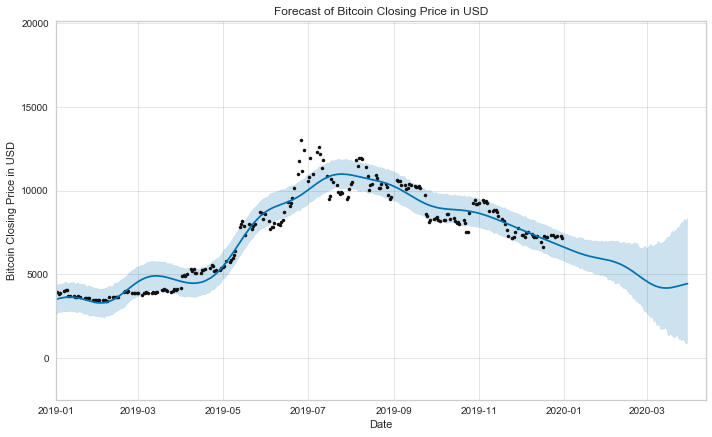

In [28]:
# Zoom in on the years 2019 and 2020
gm_prophet.plot(gm_forecast, xlabel='Date', ylabel='Bitcoin Closing Price in USD')
plt.xlim([datetime.date(2019, 1, 1)], [datetime.date(2020, 4, 12)])
plt.title('Forecast of Bitcoin Closing Price in USD')
plt.show()

I used the changepoint_prior_scale and custom seasonality parameters to tune the model. If the model was overfittting (too much flexibility), I decreased the changepoint prior scale, and if it was underfitting (too little flexibility), I increased the changepoint prior scale. I settled on a value of 1 (default is 0.05). I also turned off the default seasonalities and added a custom seasonality to account for the peaks every 1 to 1.5 years.

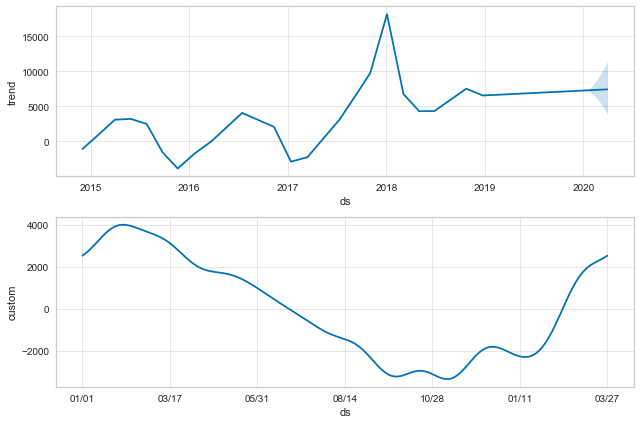

In [29]:
# Look at the trend and seasonality components of
# the bitcoin forecast
gm_prophet.plot_components(gm_forecast);

In [30]:
# Use built-in cross validation to assess prediction
# performance on a horizon of three months
fbp_cv = cross_validation(gm_prophet, initial='730 days', period='30 days', horizon='60 days')

fbp_cv.head()

INFO:fbprophet:Making 36 forecasts with cutoffs between 2016-12-16 00:00:00 and 2019-11-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-12-19,788.500895,766.637238,810.706861,792.713989,2016-12-16
1,2016-12-20,789.873986,767.066025,814.173930,800.875977,2016-12-16
2,2016-12-21,791.346371,768.788926,812.918830,834.281006,2016-12-16
3,2016-12-22,792.948515,769.853511,815.125642,864.539978,2016-12-16
4,2016-12-23,794.710858,770.553965,816.667179,921.984009,2016-12-16


Note: Initial refers to the size of the initial training period, horizon refers to the forecast horizon, and period refers to the spacing between cutoff dates. Here, I assess prediction performance on a horizon of 60 days, starting with 730 days of training data in the first cutoff and then making predictions every 30 days. This corresponds to 36 forecasts.

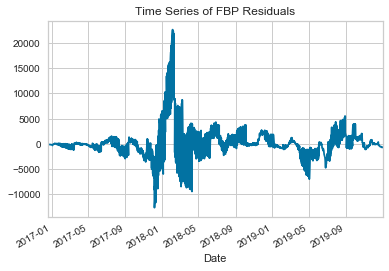

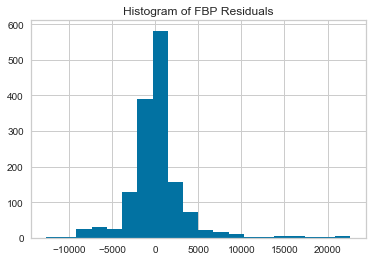

In [31]:
# Calculate residuals
residuals = pd.DataFrame(fbp_cv['yhat'] - fbp_cv['y'])
residuals['date'] = fbp_cv['ds']

# Plot time series and histogram of residuals
residuals.plot(x='date', legend=False)
plt.xlabel('Date')
plt.title('Time Series of FBP Residuals')

residuals.hist(bins=20)
plt.title('Histogram of FBP Residuals')

plt.show()

In [32]:
# Use built-in performance metrics to evaluate model
fbp_p = performance_metrics(fbp_cv)
fbp_p

,horizon,mse,rmse,mae,mape,coverage
0,6 days,9.447973e+05,972.006851,677.278973,0.110485,0.456081
1,7 days,1.181061e+06,1086.766332,718.329449,0.115467,0.437838
2,8 days,1.373043e+06,1171.769086,760.178809,0.122845,0.422297
3,9 days,1.572766e+06,1254.099675,808.142754,0.129109,0.399688
4,10 days,1.639450e+06,1280.410089,832.904333,0.132416,0.379189
5,11 days,1.980498e+06,1407.301635,890.944308,0.137410,0.350000
6,12 days,2.246058e+06,1498.685372,944.191418,0.145851,0.330042
7,13 days,2.508671e+06,1583.878499,1001.730422,0.154095,0.310270
8,14 days,2.867799e+06,1693.457589,1080.373287,0.162408,0.283784
9,15 days,3.147972e+06,1774.252416,1157.408959,0.172239,0.263514


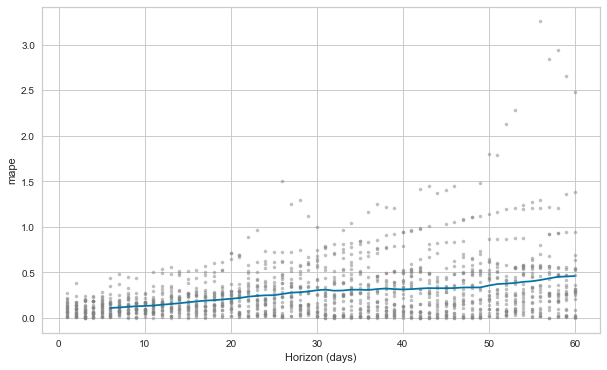

In [33]:
# Plot MAPE metric from cross validation
mape_fig = plot_cross_validation_metric(fbp_cv, metric='mape')

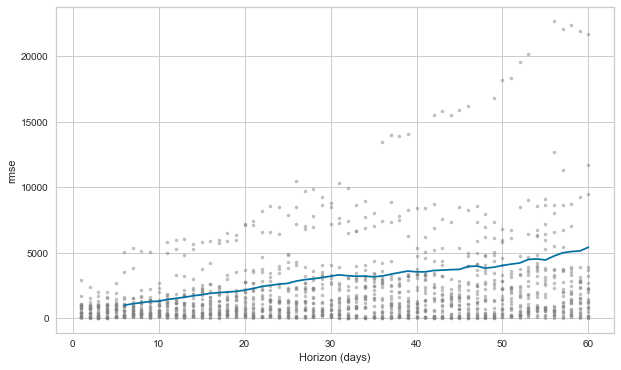

In [34]:
# Plot RMSE metric from cross validation
rmse_fig = plot_cross_validation_metric(fbp_cv, metric='rmse')

By manually tuning the fb prophet parameters, I was able to reduce the 6-day RMSE and MAPE from 2590.143614 and 26.9316% to 951.732851 and 10.4503%, respectively.

In [35]:
# Store forecasted prices in a data frame
fbp = gm_forecast[['ds', 'yhat']][(gm_forecast['ds'] >= datetime.date(2020, 1, 1)) & (gm_forecast['ds'] < datetime.date(2020, 4, 13))]
fbp.rename(columns={'ds': 'date', 'yhat': 'fbp_forecast'}, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


In [36]:
# Add forecasted prices to actual data frame for comparison
actual = actual.merge(fbp, how='inner', left_on='date', right_on='date')
actual

,actual_close,date,fbp_forecast
0,7200.174316,2020-01-01,6623.369216
1,6985.470215,2020-01-02,6588.544523
2,7344.884277,2020-01-03,6553.886240
3,7410.656738,2020-01-04,6519.470163
4,7411.317383,2020-01-05,6485.377436
...,...,...,...
85,6716.440430,2020-03-26,4354.392369
86,6469.798340,2020-03-27,4376.606467
87,6242.193848,2020-03-28,4397.854482
88,5922.042969,2020-03-29,4417.721627


In [37]:
# Use RMSE and MAE to evaluate 7-day performance of prophet model
print('Facebook Prophet 7-Day Performance')
print('\nRoot mean squared error: %.2f'
      % mean_squared_error(actual['actual_close'][0:7], actual['fbp_forecast'][0:7]) ** 0.5)

print('\nMean absolute error: %.2f'
      % mean_absolute_error(actual['actual_close'][0:7], actual['fbp_forecast'][0:7]))

Facebook Prophet 7-Day Performance

Root mean squared error: 1038.48

Mean absolute error: 949.22


In [38]:
# Use RMSE and MAE to evaluate 90-day performance of prophet model
print('Facebook Prophet 90-Day Performance')
print('\nRoot mean squared error: %.2f'
      % mean_squared_error(actual['actual_close'], actual['fbp_forecast']) ** 0.5)

print('\nMean absolute error: %.2f'
      % mean_absolute_error(actual['actual_close'], actual['fbp_forecast']))

Facebook Prophet 90-Day Performance

Root mean squared error: 3271.15

Mean absolute error: 2999.27


### VAR Model
The code for this model is adapted from https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/.

In [39]:
# Change index to values in date column
final_var = final.set_index('date')
final_var.head()

,bitcoin_close,cpi_close,dow_close,sp_close,usd_close,vix_close,interest,trend,unemploy
date,,,,,,,,,
2014-12-01,379.244995,26.660000,17776.800781,2053.439941,87.949997,14.16,0.01,3.0,5.6
2014-12-02,381.315002,26.690001,17879.550781,2066.550049,88.650002,12.85,0.04,3.0,5.6
2014-12-03,375.010010,26.750000,17912.619141,2074.330078,88.959999,12.50,0.03,3.0,5.6
2014-12-04,369.604004,26.670000,17900.099609,2071.919922,88.699997,12.38,0.03,3.0,5.6
2014-12-05,376.854004,26.680000,17958.789063,2075.370117,89.330002,11.89,0.02,3.0,5.6


In [40]:
# Use Granger's causality test to determine if 
# the time series influence each other
maxlag=12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(final_var, variables=final_var.columns)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


,bitcoin_close_x,cpi_close_x,dow_close_x,sp_close_x,usd_close_x,vix_close_x,interest_x,trend_x,unemploy_x
bitcoin_close_y,1.0000,0.0558,0.0833,0.1072,0.8879,0.5793,0.1387,0.0000,0.0743
cpi_close_y,0.0005,1.0000,0.0000,0.0000,0.0427,0.0000,0.0020,0.0093,0.0000
dow_close_y,0.0304,0.0086,1.0000,0.1667,0.1429,0.0660,0.0582,0.0000,0.0022
sp_close_y,0.0345,0.0023,0.1090,1.0000,0.2738,0.0354,0.0944,0.0000,0.0050
usd_close_y,0.0771,0.0260,0.3394,0.3501,1.0000,0.1541,0.1076,0.0006,0.2730
vix_close_y,0.0672,0.0001,0.3284,0.0982,0.2786,1.0000,0.1288,0.0000,0.4977
interest_y,0.3583,0.5386,0.1625,0.2323,0.1361,0.0374,1.0000,0.0068,0.0068
trend_y,0.0003,0.2890,0.0744,0.1902,0.6262,0.1096,0.0000,1.0000,0.4370
unemploy_y,0.3998,0.0426,0.1022,0.1232,0.1306,0.2181,0.3525,0.8895,1.0000


Interest, trend, unemployment, usd, and vix seem to have the least affect on the other variables (p-value > 0.05), so I will drop these columns from the final_var data set.

In [41]:
# Change index to values in date column
final_var.drop(columns=['interest', 'trend', 'unemploy', 'usd_close', 'vix_close'], inplace=True)
final_var.head()

,bitcoin_close,cpi_close,dow_close,sp_close
date,,,,
2014-12-01,379.244995,26.660000,17776.800781,2053.439941
2014-12-02,381.315002,26.690001,17879.550781,2066.550049
2014-12-03,375.010010,26.750000,17912.619141,2074.330078
2014-12-04,369.604004,26.670000,17900.099609,2071.919922
2014-12-05,376.854004,26.680000,17958.789063,2075.370117


In [42]:
# Recheck for causation between variables
grangers_causation_matrix(final_var, variables=final_var.columns)

,bitcoin_close_x,cpi_close_x,dow_close_x,sp_close_x
bitcoin_close_y,1.0000,0.0558,0.0833,0.1072
cpi_close_y,0.0005,1.0000,0.0000,0.0000
dow_close_y,0.0304,0.0086,1.0000,0.1667
sp_close_y,0.0345,0.0023,0.1090,1.0000


A few of the p-values are still greater than 0.05, but they are closer to the significance cutoff than the other variables, so I will continue with these 4 time series data sets.

In [43]:
# Check for cointegration between the time series
# Cointegration refers to the presence of a statistically
# significant relationship between two or more time series
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(final_var)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
bitcoin_close ::  19.88     > 40.1749   =>   False
cpi_close ::  7.87      > 24.2761   =>   False
dow_close ::  3.45      > 12.3212   =>   False
sp_close ::  1.12      > 4.1296    =>   False


None of the time series are statistically connected with each other. However, I will continue with these four data sets for the sake of evaluating and comparing the VAR model to the other models.

In [44]:
# Use the Augmented Dickey-Fuller Test (ADF Test)
# to check if time series are stationary
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [45]:
# Run ADF Test on each column
for name, column in final_var.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "bitcoin_close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.6834
 No. Lags Chosen       = 18
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.4397. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "cpi_close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.2979
 No. Lags Chosen       = 10
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.6301. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "dow_close" 
    -----------------------------------------------
 Null Hypothe

In [46]:
# Take first difference
final_var_diff_1 = final_var.diff().dropna()

# Rerun ADF Test on each column
for name, column in final_var_diff_1.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "bitcoin_close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.38
 No. Lags Chosen       = 17
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "cpi_close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.1781
 No. Lags Chosen       = 9
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "dow_close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significan

All four time series are stationary after taking the first difference.

In [47]:
# Determine the order (P) of the VAR model using AIC
model = VAR(final_var_diff_1)

for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  19.849617111360025
BIC :  19.930361397628126
FPE :  417425762.388808
HQIC:  19.879940625225757 

Lag Order = 2
AIC :  19.80759898018802
BIC :  19.95303055075534
FPE :  400250003.3199808
HQIC:  19.862217923690185 

Lag Order = 3
AIC :  19.796529099648673
BIC :  20.006729786837738
FPE :  395844467.45323527
HQIC:  19.87547609763464 

Lag Order = 4
AIC :  19.799579794662534
BIC :  20.074631600398515
FPE :  397055308.93693274
HQIC:  19.902887541452177 

Lag Order = 5
AIC :  19.814713681939246
BIC :  20.154698778234536
FPE :  403112276.7480134
HQIC:  19.942414941526657 

Lag Order = 6
AIC :  19.82808166788214
BIC :  20.233082397322697
FPE :  408540645.15888
HQIC:  19.98020927413805 

Lag Order = 7
AIC :  19.822727391357855
BIC :  20.292826267591323
FPE :  406363709.1409218
HQIC:  19.999314248232828 

Lag Order = 8
AIC :  19.812291508669503
BIC :  20.347571216895112
FPE :  402151090.3505977
HQIC:  20.013370590397876 

Lag Order = 9
AIC :  19.818380541402995
BIC :  20.4189

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag 3 produces the smallest AIC before increasing again at lag 4, so I will continue with a 3rd order VAR model.

In [48]:
# Build 3rd order VAR model
model_fit = model.fit(3)
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, Apr, 2020
Time:                     22:29:48
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    20.0067
Nobs:                     1274.00    HQIC:                   19.8755
Log likelihood:          -19789.3    FPE:                3.95844e+08
AIC:                      19.7965    Det(Omega_mle):     3.80091e+08
--------------------------------------------------------------------
Results for equation bitcoin_close
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    5.196982         9.264911            0.561           0.575
L1.bitcoin_close        -0.027424         0.028064           -0.977           0.328
L1.cpi_close            46.910844       

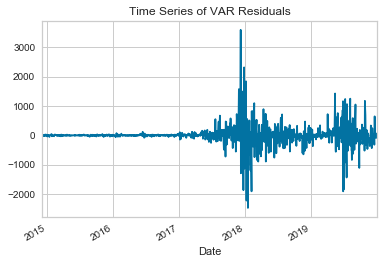

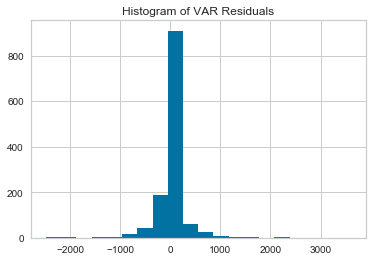

In [49]:
# Plot time series and histogram of residuals
residuals = pd.DataFrame(model_fit.resid['bitcoin_close'])

residuals.plot(legend=False)
plt.xlabel('Date')
plt.title('Time Series of VAR Residuals')

residuals.hist(bins=20)
plt.title('Histogram of VAR Residuals')

plt.show()

In [50]:
# Test normality of errors/residuals (Jarque-Bera)
# Null hypothesis equals data is normal
print(model_fit.test_normality(signif=0.05))

<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 5% significance level. Test statistic: 60957.464, critical value: 15.507>, p-value: 0.000>


Unfortunately, the p-values for the bitcoin-related coefficients are not signficant (greater than 0.05), indicating that these terms are not playing a signficant role in the model.

In [51]:
# Load VAR test sets
bit_var = pd.read_csv('yahoo_BTC-USD_d_test.csv')
cpi_var = pd.read_csv('yahoo_CPI_d_test.csv')
dow_var = pd.read_csv('yahoo_DJI_d_test.csv')
sp_var = pd.read_csv('yahoo_SP500_d_test.csv')

# Clean and merge data sets
df_list = [bit_var, cpi_var, dow_var, sp_var]
name_list = ['bit_var', 'cpi_var', 'dow_var', 'sp_var']

for i, df in enumerate(df_list):
    df['date'] = pd.to_datetime(df['Date'])
    df.drop(['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
    df.rename(columns={'Close': 'actual_' + '{}'.format(name_list[i])}, inplace=True)

var_test = bit_var[['date', 'actual_bit_var']].copy()  

merge_list = [cpi_var, dow_var, sp_var]

for df in merge_list:
    var_test = var_test.merge(df, how='inner', on='date')

# Use forward fill to fill in missing values
var_test.fillna(method='ffill', inplace=True)

# Change index to values in date column
var_test = var_test.set_index('date')

# Take first difference
var_test_diff_1 = var_test.diff().dropna()

# Check final test data frame
var_test_diff_1

,actual_bit_var,actual_cpi_var,actual_dow_var,actual_sp_var
date,,,,
2020-01-03,359.414062,0.040001,-233.91992,-23.000000
2020-01-06,424.334961,0.000000,68.50000,11.429931
2020-01-07,394.473145,0.010000,-119.70117,-9.100097
2020-01-08,-83.829590,-0.020000,161.41015,15.870117
2020-01-09,-200.791504,0.000000,211.81055,21.649902
...,...,...,...,...
2020-04-03,-60.237305,0.269998,-360.91015,-38.250000
2020-04-06,538.394043,0.380001,1627.46093,175.030030
2020-04-07,-95.366699,0.029999,-26.13085,-4.270020


In [52]:
# Get the lag order
lag_order = model_fit.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = var_test_diff_1.values[-lag_order:]
forecast_input

3


array([[-9.53666990e+01,  2.99990000e-02, -2.61308500e+01,
        -4.27002000e+00],
       [ 1.57684082e+02,  1.90001000e-01,  7.79710930e+02,
         9.05700680e+01],
       [-3.20092780e+01,  1.30001000e-01,  2.85798830e+02,
         3.98400880e+01]])

In [53]:
# Forecast (remember the output will be in scale
# of first differenced data)
nobs = 69
fc = model_fit.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=var_test.index[-nobs:], columns=var_test.columns + '_1d')
df_forecast

,actual_bit_var_1d,actual_cpi_var_1d,actual_dow_var_1d,actual_sp_var_1d
date,,,,
2020-01-02,10.425617,-0.035980,-15.527164,-2.931145
2020-01-03,-16.841525,0.018038,19.690255,0.340815
2020-01-06,-17.124899,0.002792,12.361627,0.167507
2020-01-07,11.244813,-0.005841,9.943667,1.319745
2020-01-08,7.647902,-0.000353,2.568417,0.243937
...,...,...,...,...
2020-04-03,5.353431,0.001056,8.405704,0.918065
2020-04-06,5.353431,0.001056,8.405704,0.918065
2020-04-07,5.353431,0.001056,8.405704,0.918065


In [54]:
# Invert transformation to get real forecast
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = var_test.columns
    
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (var_test[col].iloc[-1]-var_test[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = var_test[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

var_results = invert_transformation(final_var, df_forecast, second_diff=False)        
var_results = var_results.loc[:, ['actual_bit_var_forecast']]
var_results.rename(columns={'actual_bit_var_forecast': 'var_forecast'}, inplace=True)
var_results

,var_forecast
date,
2020-01-02,7312.514972
2020-01-03,7295.673447
2020-01-06,7278.548548
2020-01-07,7289.793361
2020-01-08,7297.441262
...,...
2020-04-03,7618.969036
2020-04-06,7624.322467
2020-04-07,7629.675898


In [55]:
# Add VAR forecast to actual data frame
actual = actual.merge(var_results, how='left', on='date')

# Use forward fill to fill in missing values
# (due to stock market being closed on the
# weekends) via imputation
actual['var_forecast'].ffill(inplace=True)

# Use back fill to fill in last missing value
actual.fillna(method='backfill', inplace=True)

# Check data frame
actual

,actual_close,date,fbp_forecast,var_forecast
0,7200.174316,2020-01-01,6623.369216,7312.514972
1,6985.470215,2020-01-02,6588.544523,7312.514972
2,7344.884277,2020-01-03,6553.886240,7295.673447
3,7410.656738,2020-01-04,6519.470163,7295.673447
4,7411.317383,2020-01-05,6485.377436,7295.673447
...,...,...,...,...
85,6716.440430,2020-03-26,4354.392369,7586.848447
86,6469.798340,2020-03-27,4376.606467,7592.201879
87,6242.193848,2020-03-28,4397.854482,7592.201879
88,5922.042969,2020-03-29,4417.721627,7592.201879


In [56]:
# Evaluate 7-day performance of model on test set
print('VAR 7-Day Performance')
print('\nRoot mean squared error: %.2f'
      % mean_squared_error(actual['actual_close'][0:7], actual['var_forecast'][0:7]) ** 0.5)

print('\nMean absolute error: %.2f'
      % mean_absolute_error(actual['actual_close'][0:7], actual['var_forecast'][0:7]))

VAR 7-Day Performance

Root mean squared error: 405.86

Mean absolute error: 297.68


In [57]:
# Evaluate 90-day performance of model on test set
print('VAR 90-Day Performance')
print('\nRoot mean squared error: %.2f'
      % mean_squared_error(actual['actual_close'], actual['var_forecast']) ** 0.5)

print('\nMean absolute error: %.2f'
      % mean_absolute_error(actual['actual_close'], actual['var_forecast']))

VAR 90-Day Performance

Root mean squared error: 1716.34

Mean absolute error: 1554.51


### ARIMA Model
Third, I will forecast the closing price of bitcoin using the ARIMA model.

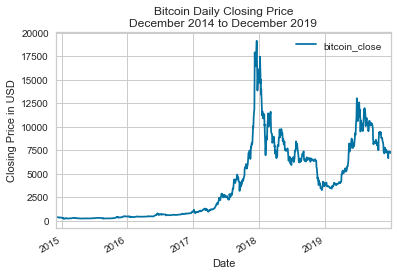

In [58]:
# Plot bitcoin time series
final.plot(x='date', y='bitcoin_close')
plt.title('Bitcoin Daily Closing Price\nDecember 2014 to December 2019')
plt.xlabel('Date')
plt.ylabel('Closing Price in USD')
plt.show()

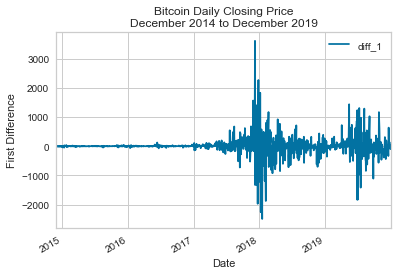

In [59]:
# Take first difference
diff = final[['date']].copy()
diff['diff_1'] = final.bitcoin_close - final.bitcoin_close.shift()

# Plot first difference to see if data set is stationary
diff.plot(x='date', y='diff_1')
plt.title('Bitcoin Daily Closing Price\nDecember 2014 to December 2019')
plt.xlabel('Date')
plt.ylabel('First Difference')
plt.show()

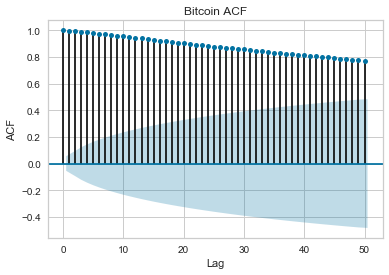

In [60]:
# Use ACF to find most optimal MA(q) model
plot_acf(final.bitcoin_close, lags=50, alpha=0.05)
plt.title('Bitcoin ACF')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

Autocorrelations are significant for a large number of lags (50+).

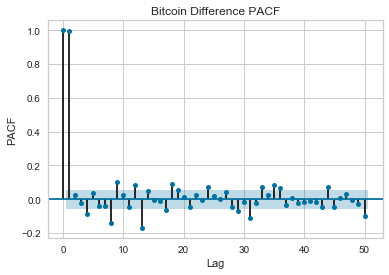

In [61]:
# Use PACF to find most optimal AR(p) model
plot_pacf(final.bitcoin_close, lags=50, alpha=0.05)
plt.title('Bitcoin Difference PACF')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

However, the PACF plot indicates that the autocorrelations seen in the ACF plot are largely due to the propagation of the autocorrelation at lag 1.

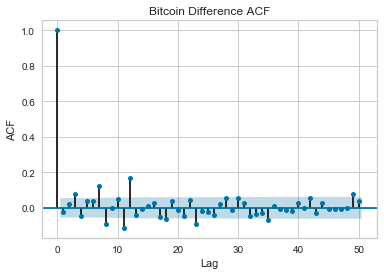

In [62]:
# Use ACF to find most optimal MA(q) model
plot_acf(diff['diff_1'][1:], lags=50, alpha=0.05)
plt.title('Bitcoin Difference ACF')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

The ACF cuts off at lag 0, suggesting that an MA term is not needed for the differenced series.

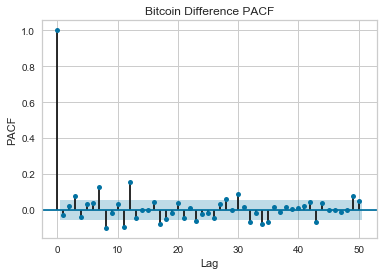

In [63]:
# Use PACF to find most optimal AR(p) model
plot_pacf(diff.diff_1[1:], lags=50, alpha=0.05)
plt.title('Bitcoin Difference PACF')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

The PACF cuts off at lag 0, suggesting that an AR term is not needed for the differenced series. Based on these analyses, I will first try an ARIMA(0, 1, 0) model.

In [64]:
# Build ARIMA(0, 1, 0) model
model = ARIMA(final.bitcoin_close, order=(0, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.bitcoin_close   No. Observations:                 1277
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -9213.431
Method:                           css   S.D. of innovations            328.969
Date:                Wed, 15 Apr 2020   AIC                          18430.863
Time:                        22:29:50   BIC                          18441.167
Sample:                             1   HQIC                         18434.732
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3362      9.206      0.580      0.562     -12.707      23.379


In [65]:
# Build ARIMA(1, 1, 0) model
model = ARIMA(final.bitcoin_close, order=(1, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.bitcoin_close   No. Observations:                 1277
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -9212.986
Method:                       css-mle   S.D. of innovations            328.855
Date:                Wed, 15 Apr 2020   AIC                          18431.972
Time:                        22:29:50   BIC                          18447.429
Sample:                             1   HQIC                         18437.777
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.3362      8.966      0.595      0.552     -12.237      22.909
ar.L1.D.bitcoin_close    -0.0264      0.028     -0.944      0.345      -0.081       0.028
        

In [66]:
# Build ARIMA(0, 1, 1) model
model = ARIMA(final.bitcoin_close, order=(0, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.bitcoin_close   No. Observations:                 1277
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -9213.005
Method:                       css-mle   S.D. of innovations            328.860
Date:                Wed, 15 Apr 2020   AIC                          18432.011
Time:                        22:29:51   BIC                          18447.467
Sample:                             1   HQIC                         18437.815
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.3362      8.971      0.595      0.552     -12.246      22.919
ma.L1.D.bitcoin_close    -0.0252      0.027     -0.925      0.355      -0.079       0.028
        

In [67]:
# Build ARIMA(1, 1, 1) model
model = ARIMA(final.bitcoin_close, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.bitcoin_close   No. Observations:                 1277
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -9212.951
Method:                       css-mle   S.D. of innovations            328.845
Date:                Wed, 15 Apr 2020   AIC                          18433.901
Time:                        22:29:51   BIC                          18454.510
Sample:                             1   HQIC                         18441.641
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.3364      8.980      0.594      0.552     -12.265      22.938
ar.L1.D.bitcoin_close    -0.1278      0.365     -0.350      0.726      -0.842       0.587
ma.L1.D.

The p-values for the AR and MR coefficients in the ARIMA(1, 1, 0), ARIMA(0, 1, 1), and ARIMA(1, 1, 1) are greater than 0.05, indicating that these coefficients do not play a significant explanatory role (and thus are not needed) when d=1.

In [68]:
# Use pd.auto_arima to optimize p and q based on AIC
stepwise_fit = pm.auto_arima(final.bitcoin_close,
                             start_p=1, max_p=3,
                             d=1,
                             start_q=1, max_q=3,
                             trace=True, # show individual results
                             seasonal=False, # don't want to correct for seasonality
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=18431.600, BIC=18452.209, Time=0.484 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=18430.863, BIC=18441.167, Time=0.030 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=18431.973, BIC=18447.429, Time=0.096 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=18432.017, BIC=18447.474, Time=0.112 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=18429.199, BIC=18434.351, Time=0.022 seconds
Total fit time: 0.748 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1278
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -9213.600
Date:                Wed, 15 Apr 2020   AIC                          18429.199
Time:                        22:29:52   BIC                          18434.351
Sample:                             0   HQIC                         18431.134
                               - 1278                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.082e+05   1146.923     94.309      0.000    1.06e+05     1.1e+05
===================================================================================
Ljung-Box (Q):                      159.16   Jarque-Bera (JB):             35467.25
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             498.76   Skew:                             0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

pm.auto_arima also confirmed that ARIMA(0, 1, 0) is the best model (smallest AIC value).

In [69]:
# Use ARIMA(0, 1, 0) model to forecast bitcoin prices
# Instantiate model
model = ARIMA(final.bitcoin_close, order=(0, 1, 0))

# Fit model
model_fit = model.fit()

# Use model to forecast and store in data frame
actual['arima_forecast'] = model_fit.forecast(steps=90)[0]
actual

,actual_close,date,fbp_forecast,var_forecast,arima_forecast
0,7200.174316,2020-01-01,6623.369216,7312.514972,7198.935342
1,6985.470215,2020-01-02,6588.544523,7312.514972,7204.271563
2,7344.884277,2020-01-03,6553.886240,7295.673447,7209.607784
3,7410.656738,2020-01-04,6519.470163,7295.673447,7214.944005
4,7411.317383,2020-01-05,6485.377436,7295.673447,7220.280226
...,...,...,...,...,...
85,6716.440430,2020-03-26,4354.392369,7586.848447,7652.514121
86,6469.798340,2020-03-27,4376.606467,7592.201879,7657.850342
87,6242.193848,2020-03-28,4397.854482,7592.201879,7663.186563
88,5922.042969,2020-03-29,4417.721627,7592.201879,7668.522784


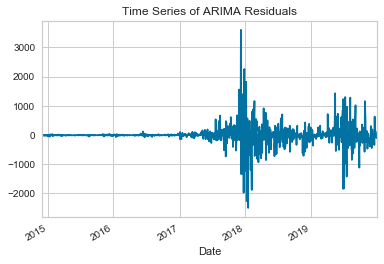

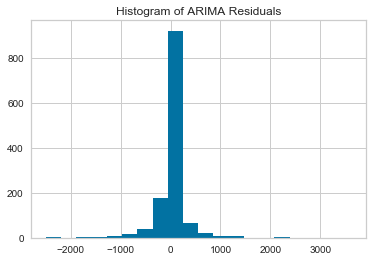

In [70]:
# Plot time series and histogram of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals['date'] = final['date'][1:]

residuals.plot(x='date', legend=False)
plt.xlabel('Date')
plt.title('Time Series of ARIMA Residuals')

residuals.hist(bins=20)
plt.title('Histogram of ARIMA Residuals')

plt.show()

In [71]:
# Test normality of errors/residuals
# Null hypothesis equals data is normal
print(jarque_bera(model_fit.resid))

(35467.25180750599, 0.0, 0.5900638407173341, 28.791094414675026)


There isn't a clear trend in the residuals, indicating that seasonality is not playing a signficant role; however, there are a few places of higher volatility (beginning of 2018 and middle of 2019). Additionally, the distribution of the residuals seems approximately normal.

In [72]:
# Use RMSE and MAE to evaluate 7-day performance of ARIMA model
print('ARIMA(0, 1, 0) 7-Day Performance')
print('\nRoot mean squared error: %.2f'
      % mean_squared_error(actual['actual_close'][0:7], actual['arima_forecast'][0:7]) ** 0.5)

print('\nMean absolute error: %.2f'
      % mean_absolute_error(actual['actual_close'][0:7], actual['arima_forecast'][0:7]))

ARIMA(0, 1, 0) 7-Day Performance

Root mean squared error: 432.02

Mean absolute error: 316.92


In [73]:
# Use RMSE and MAE to evaluate 90-day performance of ARIMA model
print('ARIMA(0, 1, 0) 90-Day Performance')
print('\nRoot mean squared error: %.2f'
      % mean_squared_error(actual['actual_close'], actual['arima_forecast']) ** 0.5)

print('\nMean absolute error: %.2f'
      % mean_absolute_error(actual['actual_close'], actual['arima_forecast']))

ARIMA(0, 1, 0) 90-Day Performance

Root mean squared error: 1732.81

Mean absolute error: 1573.53


### Ensemble Models: Linear Regression Plus ARIMA and Random Forest Regressor Plus ARIMA
Finally, I will use an ensemble modeling approach in which I will predict bitcoin prices using a supervised learning model (linear regression or random forest regressor) and then feed those predicted prices into an ARIMA model. Why does predicting bitcoin prices based on external variables/features lead to a more accurate ARIMA forecast? Try LR with ARIMA. Use ARIMA results to create range or combine supervised learning models (take best prediction for each date) and feed that into ARIMA.

#### Select Features Using PCA

In [74]:
# Set feature and target variables
X = final[['cpi_close', 'dow_close', 'sp_close', 'usd_close', 'vix_close', 'interest', 'trend', 'unemploy']]
y = final['bitcoin_close']

# Standardize features
X = StandardScaler().fit_transform(X)

# Perform PCA
pca = PCA(n_components=8)
principal_components = pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component:\n',
    pca.explained_variance_ratio_,
    '\n\nThe cumulative percentage of total variance in the dataset explained by',
    'the components:\n',
    pca.explained_variance_ratio_.cumsum()
)

The percentage of total variance in the dataset explained by each component:
 [6.16835810e-01 1.58843724e-01 1.37605806e-01 6.14739344e-02
 1.53835166e-02 7.27959085e-03 2.36433919e-03 2.13278158e-04] 

The cumulative percentage of total variance in the dataset explained by the components:
 [0.61683581 0.77567953 0.91328534 0.97475928 0.99014279 0.99742238
 0.99978672 1.        ]


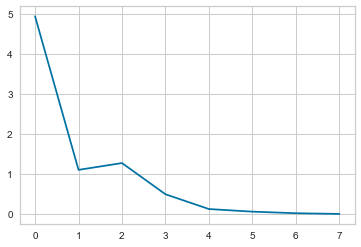

[4.93855076e+00 1.10170851e+00 1.27174490e+00 4.92176590e-01
 1.23164506e-01 5.82823311e-02 1.89295253e-02 1.70756138e-03]


In [75]:
# Print scree plot
Xt = X.T
Cx = np.cov(Xt)

eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

Since I only have 8 variables, I used PCA to reduce correlation and improve independence between the external variables rather than to reduce the overall dimensions. Thus, I will continue with all 8 components as features in the downstream supervised models.

In [76]:
# Use all 8 components as features in model
pca = PCA(n_components=1)
principal_components = pca.fit_transform(X)
X_pca = pd.DataFrame(data=principal_components)
X_pca

,0
0,-2.568411
1,-2.486578
2,-2.428736
3,-2.488523
4,-2.476006
...,...
1273,3.667924
1274,3.738428
1275,3.747015
1276,3.143367


#### Linear Regression Model

In [77]:
# Create training and testing sets from X_pca and y
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=1234)

In [78]:
# Instantiate model
lrm = linear_model.LinearRegression()

# Fit model
lrm.fit(X_train, y_train)

# Use model to predict prices in X_test
y_pred = lrm.predict(X_test)

# Evaluate performance of model on test set
print('Coefficients:\n', lrm.coef_)

print('\nMean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

print('\nRoot mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred) ** 0.5)

print('\nR squared: %.2f'
      % r2_score(y_test, y_pred))

Coefficients:
 [1570.76756718]

Mean squared error: 3632685.20

Root mean squared error: 1905.96

R squared: 0.75


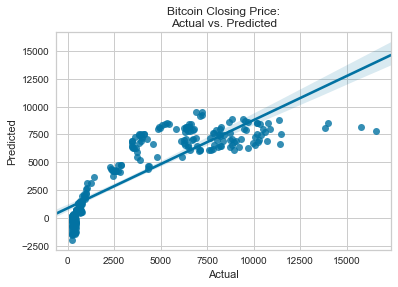

In [79]:
# Look at correlation between actual and predicted prices
sns.regplot(x=y_test, y=y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Bitcoin Closing Price:\nActual vs. Predicted')

plt.show()

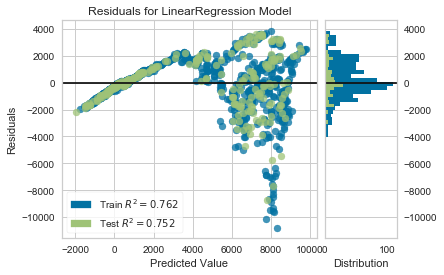

In [80]:
# Create the visualizer, fit, score, and show it
viz = residuals_plot(linear_model.LinearRegression(), X_train, y_train, X_test, y_test)

The R-squared values for both the training and test sets are quite high (about 0.9) and similar, suggesting that the model is not overfitting. However, there is some pattern to the residuals, indicating that there is room for improvement.

#### Linear Regressor ARIMA Ensemble Model

In [81]:
# Instantiate model
lrm = linear_model.LinearRegression()

# Fit model
lrm.fit(X_pca, y)

# Use model to predict prices in X_test
y_pred = lrm.predict(X_pca)

# Store predicted values in a new data frame
lrm_final = final[['date']].copy()
lrm_final['lrm_bitcoin_close'] = y_pred

# Check data frame
lrm_final

,date,lrm_bitcoin_close
0,2014-12-01,-95.633371
1,2014-12-02,31.673577
2,2014-12-03,121.658370
3,2014-12-04,28.647439
4,2014-12-05,48.119745
...,...,...
1273,2019-12-24,9606.182737
1274,2019-12-26,9715.865877
1275,2019-12-27,9729.225158
1276,2019-12-30,8790.134915


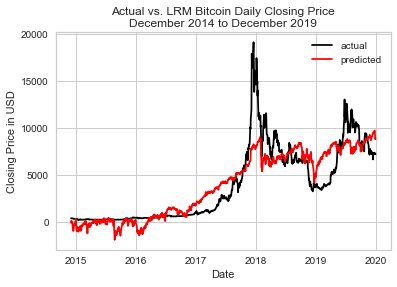

In [82]:
# Plot lrm predicted bitcoin time series
plt.plot(final['date'], final['bitcoin_close'], c='black', label='actual')
plt.plot(final['date'], lrm_final['lrm_bitcoin_close'], c='red', label='predicted')

plt.title('Actual vs. LRM Bitcoin Daily Closing Price\nDecember 2014 to December 2019')
plt.xlabel('Date')
plt.ylabel('Closing Price in USD')
plt.legend()
plt.show()

In [83]:
# Use pd.auto_arima to optimize p and q based on AIC
stepwise_fit = pm.auto_arima(lrm_final.lrm_bitcoin_close,
                             start_p=1, max_p=3,
                             d=1,
                             start_q=1, max_q=3,
                             trace=True, # show individual results
                             seasonal=False, # don't want to correct for seasonality
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=16967.809, BIC=16988.418, Time=0.444 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=16964.702, BIC=16975.006, Time=0.055 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=16965.832, BIC=16981.288, Time=0.089 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=16965.823, BIC=16981.280, Time=0.067 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=16964.530, BIC=16969.682, Time=0.019 seconds
Total fit time: 0.679 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1278
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8481.265
Date:                Wed, 15 Apr 2020   AIC                          16964.530
Time:                        22:29:55   BIC                          16969.682
Sample:                             0   HQIC                         16966.465
                               - 1278                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.435e+04    617.436     55.638      0.000    3.31e+04    3.56e+04
===================================================================================
Ljung-Box (Q):                       27.47   Jarque-Bera (JB):              3412.93
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -0.84
Prob(H) (two-sided):                  0.23   Kurtosis:                        10.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
# Forecast using ARIMA(2, 1, 1) model
# Instantiate model
model = ARIMA(lrm_final.lrm_bitcoin_close, order=(0, 1, 0))

# Fit model
model_fit = model.fit()

# Use model to forecast and store in data frame
actual['lrm_arima_forecast'] = model_fit.forecast(steps=90)[0]
actual

,actual_close,date,fbp_forecast,var_forecast,arima_forecast,lrm_arima_forecast
0,7200.174316,2020-01-01,6623.369216,7312.514972,7198.935342,8867.327538
1,6985.470215,2020-01-02,6588.544523,7312.514972,7204.271563,8874.340810
2,7344.884277,2020-01-03,6553.886240,7295.673447,7209.607784,8881.354081
3,7410.656738,2020-01-04,6519.470163,7295.673447,7214.944005,8888.367353
4,7411.317383,2020-01-05,6485.377436,7295.673447,7220.280226,8895.380624
...,...,...,...,...,...,...
85,6716.440430,2020-03-26,4354.392369,7586.848447,7652.514121,9463.455611
86,6469.798340,2020-03-27,4376.606467,7592.201879,7657.850342,9470.468883
87,6242.193848,2020-03-28,4397.854482,7592.201879,7663.186563,9477.482154
88,5922.042969,2020-03-29,4417.721627,7592.201879,7668.522784,9484.495426


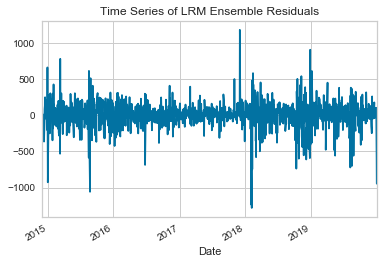

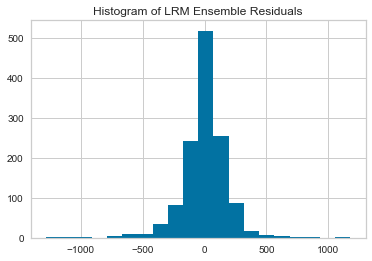

In [85]:
# Plot time series and histogram of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals['date'] = final['date'][1:]

residuals.plot(x='date', legend=False)
plt.xlabel('Date')
plt.title('Time Series of LRM Ensemble Residuals')

residuals.hist(bins=20)
plt.title('Histogram of LRM Ensemble Residuals')

plt.show()

In [86]:
# Test normality of errors/residuals
# Null hypothesis equals data is normal
print(jarque_bera(model_fit.resid))

(3412.934584260379, 0.0, -0.8402397151234202, 10.830635169862704)


#### Random Forest Regressor

In [87]:
# Instantiate model
rfr = RandomForestRegressor()

# Fit model
rfr.fit(X_train, y_train)

# Use model to predict prices in X_test
y_pred = rfr.predict(X_test)

In [88]:
# # Evaluate performance of model on test set
print('\nMean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

print('\nRoot mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred) ** 0.5)

print('\nR squared: %.2f'
      % r2_score(y_test, y_pred))


Mean squared error: 4141852.30

Root mean squared error: 2035.15

R squared: 0.72


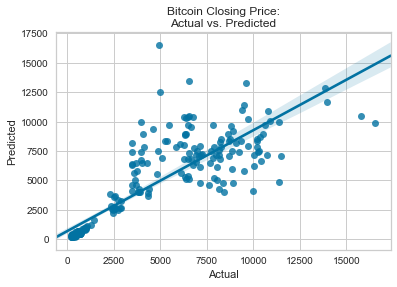

In [89]:
sns.regplot(x=y_test, y=y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Bitcoin Closing Price:\nActual vs. Predicted')

plt.show()

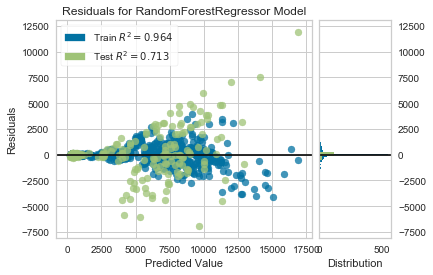

In [90]:
# Create the visualizer, fit, score, and show it
viz = residuals_plot(RandomForestRegressor(), X_train, y_train, X_test, y_test)

The random forest regressor performed significantly better than the linear regressor, as indicated by increased R-squared values for both the training and test sets, as well as more random residuals (no pattern). Thus, I will use the predictions from the random forest model, rather than the linear regression model, to feed into the ARIMA model.

#### Random Forest Regressor ARIMA Ensemble Model

In [91]:
# Instantiate model
rfr = RandomForestRegressor()

# Fit model
rfr.fit(X_pca, y)

# Use model to predict bitcoin prices
y_pred = rfr.predict(X_pca)

# Store predicted values in a new data frame
rfr_final = final[['date']].copy()
rfr_final['rfr_bitcoin_close'] = y_pred

# Check data frame
rfr_final

,date,rfr_bitcoin_close
0,2014-12-01,377.541024
1,2014-12-02,389.392479
2,2014-12-03,345.570593
3,2014-12-04,391.036928
4,2014-12-05,345.748010
...,...,...
1273,2019-12-24,7314.726226
1274,2019-12-26,7265.351782
1275,2019-12-27,7285.800415
1276,2019-12-30,8250.235762


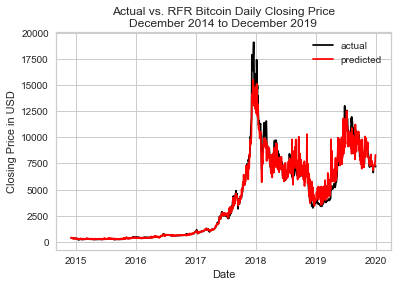

In [92]:
# Plot rfr predicted bitcoin time series
plt.plot(final['date'], final['bitcoin_close'], c='black', label='actual')
plt.plot(final['date'], rfr_final['rfr_bitcoin_close'], c='red', label='predicted')

plt.title('Actual vs. RFR Bitcoin Daily Closing Price\nDecember 2014 to December 2019')
plt.xlabel('Date')
plt.ylabel('Closing Price in USD')
plt.legend()
plt.show()

In [93]:
# Use pd.auto_arima to optimize p and q based on AIC
stepwise_fit = pm.auto_arima(rfr_final.rfr_bitcoin_close,
                             start_p=1, max_p=3,
                             d=1,
                             start_q=1, max_q=3,
                             trace=True, # show individual results
                             seasonal=False, # don't want to correct for seasonality
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=19905.477, BIC=19926.086, Time=0.379 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=20230.545, BIC=20240.850, Time=0.029 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=20007.660, BIC=20023.117, Time=0.066 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=19904.934, BIC=19920.391, Time=0.088 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=20228.657, BIC=20233.809, Time=0.021 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=19905.411, BIC=19926.020, Time=0.554 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=19908.078, BIC=19933.840, Time=0.382 seconds
Total fit time: 1.525 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1278
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -9949.467
Date:                Wed, 15 Apr 2020   AIC                          19904.934
Time:                        22:29:59   BIC                          19920.391
Sample:                             0   HQIC                         19910.738
                               - 1278                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.4894      7.505      1.531      0.126      -3.221      26.200
ma.L1         -0.5568      0.012    -46.922      0.000      -0.580      -0.534
sigma2      3.447e+05   6900.709     49.952      0.000    3.31e+05    3.58e+05
===================================================================================
Ljung-Box (Q):                       76.91   Jarque-Bera (JB):              2080.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             490.34   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
# Forecast using ARIMA(0, 1, 0) model
# Instantiate model
model = ARIMA(rfr_final.rfr_bitcoin_close, order=(0, 1, 1))

# Fit model
model_fit = model.fit()

# Use model to forecast and store in data frame
actual['rfr_arima_forecast'] = model_fit.forecast(steps=90)[0]
actual

,actual_close,date,fbp_forecast,var_forecast,arima_forecast,lrm_arima_forecast,rfr_arima_forecast
0,7200.174316,2020-01-01,6623.369216,7312.514972,7198.935342,8867.327538,7991.826336
1,6985.470215,2020-01-02,6588.544523,7312.514972,7204.271563,8874.340810,7997.791912
2,7344.884277,2020-01-03,6553.886240,7295.673447,7209.607784,8881.354081,8003.757488
3,7410.656738,2020-01-04,6519.470163,7295.673447,7214.944005,8888.367353,8009.723064
4,7411.317383,2020-01-05,6485.377436,7295.673447,7220.280226,8895.380624,8015.688640
...,...,...,...,...,...,...,...
85,6716.440430,2020-03-26,4354.392369,7586.848447,7652.514121,9463.455611,8498.900309
86,6469.798340,2020-03-27,4376.606467,7592.201879,7657.850342,9470.468883,8504.865885
87,6242.193848,2020-03-28,4397.854482,7592.201879,7663.186563,9477.482154,8510.831461
88,5922.042969,2020-03-29,4417.721627,7592.201879,7668.522784,9484.495426,8516.797037


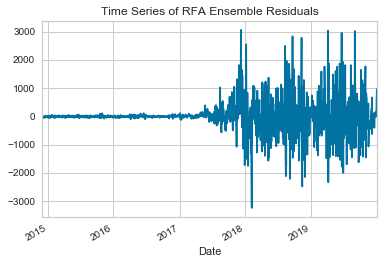

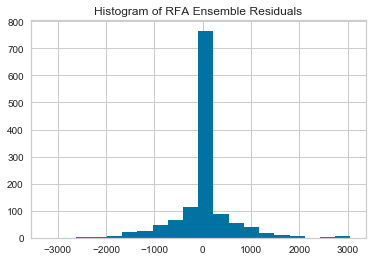

In [95]:
# Plot time series and histogram of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals['date'] = final['date'][1:]

residuals.plot(x='date', legend=False)
plt.xlabel('Date')
plt.title('Time Series of RFA Ensemble Residuals')

residuals.hist(bins=20)
plt.title('Histogram of RFA Ensemble Residuals')

plt.show()

In [96]:
# Test normality of errors/residuals
# Null hypothesis equals data is normal
print(jarque_bera(model_fit.resid))

(2082.0571880656926, 0.0, 0.4906499883305686, 9.17797169262519)


As seen previously, there is no clear pattern in the residuals and the distribution is approximately normal.

In [97]:
# Evaluate 7-day performance of model on test set
print('Random Forest and ARIMA(1, 1, 2) 7-Day Performance')
print('\nRoot mean squared error: %.2f'
      % mean_squared_error(actual['actual_close'][0:7], actual['rfr_arima_forecast'][0:7]) ** 0.5)

print('\nMean absolute error: %.2f'
      % mean_absolute_error(actual['actual_close'][0:7], actual['rfr_arima_forecast'][0:7]))

Random Forest and ARIMA(1, 1, 2) 7-Day Performance

Root mean squared error: 642.76

Mean absolute error: 579.26


In [98]:
# Evaluate 90-day performance of model on test set
print('Random Forest and ARIMA(1, 1, 2) 90-Day Performance')
print('\nRoot mean squared error: %.2f'
      % mean_squared_error(actual['actual_close'], actual['rfr_arima_forecast']) ** 0.5)

print('\nMean absolute error: %.2f'
      % mean_absolute_error(actual['actual_close'], actual['rfr_arima_forecast']))

Random Forest and ARIMA(1, 1, 2) 90-Day Performance

Root mean squared error: 1517.71

Mean absolute error: 1233.63


## Results Summary

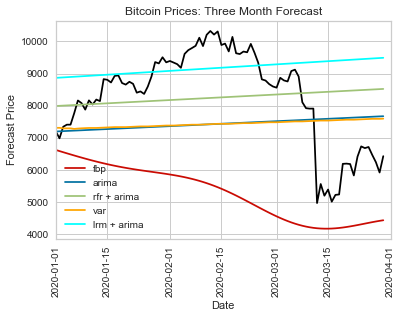

In [99]:
# Plot predicted values vs. actual values
plt.plot(actual['date'], actual['actual_close'], c='black')
plt.plot(actual['date'], actual['fbp_forecast'], c='r', label='fbp')
plt.plot(actual['date'], actual['arima_forecast'], c='b', label='arima')
plt.plot(actual['date'], actual['rfr_arima_forecast'], c='g', label='rfr + arima')
plt.plot(actual['date'], actual['var_forecast'], c='orange', label='var')
plt.plot(actual['date'], actual['lrm_arima_forecast'], c='cyan', label='lrm + arima')

plt.xlim([datetime.date(2020, 1, 1)], [datetime.date(2020, 4, 1)])
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Forecast Price')
plt.title('Bitcoin Prices: Three Month Forecast')
plt.legend(loc='lower left')

plt.show()

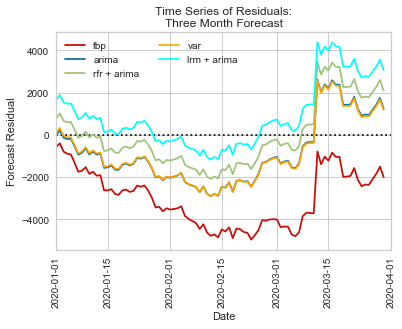

In [100]:
plt.plot(actual['date'], actual['fbp_forecast'] - actual['actual_close'], c='r', label='fbp')
plt.plot(actual['date'], actual['arima_forecast'] - actual['actual_close'], c='b', label='arima')
plt.plot(actual['date'], actual['rfr_arima_forecast'] - actual['actual_close'], c='g', label='rfr + arima')
plt.plot(actual['date'], actual['var_forecast'] - actual['actual_close'], c='orange', label='var')
plt.plot(actual['date'], actual['lrm_arima_forecast'] - actual['actual_close'], c='cyan', label='lrm + arima')

plt.hlines(0, xmin=[datetime.date(2020, 1, 1)], xmax=[datetime.date(2020, 4, 1)], colors='k', linestyles='dotted')
plt.xlim([datetime.date(2020, 1, 1)], [datetime.date(2020, 4, 1)])
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Forecast Residual')
plt.title('Time Series of Residuals:\nThree Month Forecast')
plt.legend(loc='upper left', ncol=2)

plt.show()

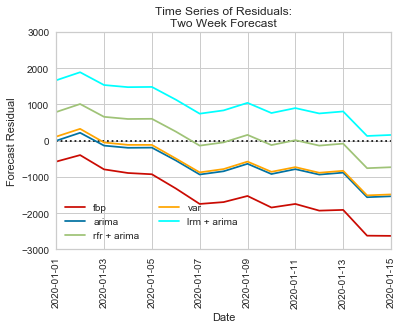

In [101]:
plt.plot(actual['date'], actual['fbp_forecast'] - actual['actual_close'], c='r', label='fbp')
plt.plot(actual['date'], actual['arima_forecast'] - actual['actual_close'], c='b', label='arima')
plt.plot(actual['date'], actual['rfr_arima_forecast'] - actual['actual_close'], c='g', label='rfr + arima')
plt.plot(actual['date'], actual['var_forecast'] - actual['actual_close'], c='orange', label='var')
plt.plot(actual['date'], actual['lrm_arima_forecast'] - actual['actual_close'], c='cyan', label='lrm + arima')

plt.hlines(0, xmin=[datetime.date(2020, 1, 1)], xmax=[datetime.date(2020, 1, 15)], colors='k', linestyles='dotted')
plt.xlim([datetime.date(2020, 1, 1)], [datetime.date(2020, 1, 15)])
plt.ylim(-3000, 3000)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Forecast Residual')
plt.title('Time Series of Residuals:\nTwo Week Forecast')
plt.legend(loc='lower left', ncol=2)

plt.show()

# TO DO:
Compare RMSE and MAE for all models. Talk about high predictive accuracy within two weeks.

## Data Product Summary

Evaluate your models. You should have built multiple models, which you should thoroughly evaluate and compare via a robust analysis of residuals and failures.


Present and thoroughly explain your product. Describe your model in detail: why you chose it, why it works, what problem it solves, how it will run in a production like environment. What would you need to do to maintain it going forward?